## Dataset Analysis

In [1]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.path.dirname(cwd), '.')) # Get the absolute path to the parent directory
sys.path.insert(0, parent_dir) # Add the parent directory to sys.path

In [2]:
dataset_dir = parent_dir + "/data" # root directory where to download the datasets
batch_size = 16
dataset_dir

'/home/joshua/Documents/phd/CompressionVAEHSI/data'

In [3]:
# loading datamodule
from src.data.bigearth_datamodule import BigEarthDataModule
dm = BigEarthDataModule(dataset_dir=dataset_dir, batch_size=batch_size, bands='all')
dm.setup()

In [4]:
dm.setup_folds(5)
dm.setup_fold_index(0)

batch = next(iter(dm.train_dataloader()))

In [5]:
x, y = batch.values()

In [6]:
dm.maxs

tensor([6.0000e+00, 1.6000e+01, 9.8590e+03, 1.2872e+04, 1.3163e+04, 1.4445e+04,
        1.2477e+04, 1.2563e+04, 1.2289e+04, 1.5596e+04, 1.2183e+04, 9.4580e+03,
        5.8970e+03, 5.5440e+03])

In [14]:
# loading dataset
from src.data.bigearth_dataset import BigEarthDataset
data = BigEarthDataset(                                                                                                                                                                                                                         
    root=dataset_dir,
    bands='all',
    download=False,
)

In [4]:
dm.setup_folds(5)
dm.setup_fold_index(0)
print("Number of train samples: ", len(dm.train_dataloader().dataset))
print("Number of validation samples: ", len(dm.val_dataloader().dataset))
print("Number of test samples: ", len(dm.test_dataloader().dataset))

Number of train samples:  332342
Number of validation samples:  83086
Number of test samples:  103857


In [6]:
batch = next(iter(dm.train_dataloader()))
x, y = batch.values()

In [6]:
import kornia.augmentation as K  
from torchgeo.transforms import AugmentationSequential
import torch

In [7]:
mins = torch.tensor(
         [-48.0, -42.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
     )
maxs = torch.tensor(
         [
             6.0,
             16.0,
             9859.0,
             12872.0,
             13163.0,
             14445.0,
             12477.0,
             12563.0,
              12289.0,                                                                                                                                                                                                                                    
             15596.0,
             12183.0,
             9458.0,
             5897.0,
             5544.0,
         ]
     )
mean = mins
std = maxs - mins

In [8]:
aug = AugmentationSequential(K.Normalize(mean=mean, std=std), data_keys=['image'])

In [9]:
norm_batch = aug(batch)

In [10]:
nx, ny = norm_batch.values()

In [11]:
nx[9,1,:,:].max()

tensor(0.8621)

In [12]:
mean

tensor([-48., -42.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.])

In [13]:
x[9,1,:,:].max()

tensor(8.)

In [54]:
import torch.nn as nn   
class CyclicBatchAnnealer(nn.Module):
    def __init__(self,
                 cycle_length: int = 34620,
                 max_value: float = 1.0, 
                 warmup_batches: int = 4*152) -> None:
        """
        Implements batch-wise cyclic annealing.

        Args:
        - cycle_length: Number of batches for a complete cycle (from 0 to max_value and back to 0).
        - max_value: Maximum value of the annealing factor, default is 1.
        """
        super(CyclicBatchAnnealer, self).__init__()
        self.update_type = 'batch'
        self.cycle_length = cycle_length
        self.max_value = max_value
        self.warmup_batches = warmup_batches
        self.current_step = 0
        self.scale = 1.0

    def forward(self) -> float:

        if self.current_step < self.warmup_batches:
            self.current_step += 1
        else:
            # Calculate the position within the current cycle
            cycle_pos = (self.current_step-self.warmup_batches) % self.cycle_length

            # Calculate the scale using a triangle sinusoidal function
            self.scale = self.max_value * (1 - abs(cycle_pos / (self.cycle_length / 2) - 1))

            self.current_step += 1

In [55]:
cyclic = CyclicBatchAnnealer(warmup_batches=0)

In [56]:
values = []
for i in range(17000):
    cyclic()
    values.append(cyclic.scale)


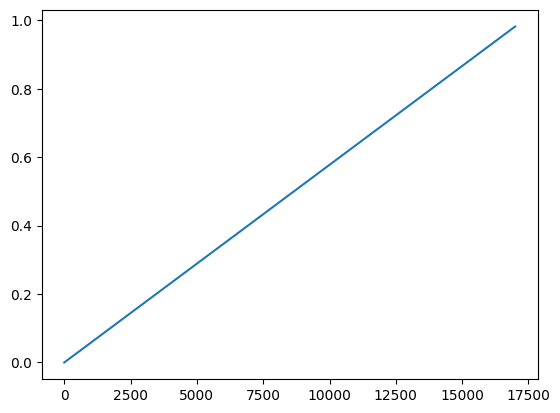

In [57]:
import matplotlib.pyplot as plt
plt.plot(values)

In [45]:
60*151

9060